In [6]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [7]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

In [20]:
# === Setup cell: run this before any analysis ===
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa

# Optional: print versions to confirm
print("Pandas:", pd.__version__)
print("Matplotlib:", plt.__version__)

# Example connection (edit this with your credentials)
HOST = "your-rds-endpoint"
DB   = "your-db-name"
USER = "your-username"
PW   = "your-password"
engine = sa.create_engine(f"postgresql+psycopg2://{USER}:{PW}@{HOST}/{DB}")

# For reference (Tennessee)
FIPS = '47'

Pandas: 2.2.3


AttributeError: module 'matplotlib.pyplot' has no attribute '__version__'

In [8]:
sql_q1 = f"""
SELECT year,
       pop,
       LAG(pop) OVER (ORDER BY year) AS prev_pop,
       ROUND(100.0 * (pop - LAG(pop) OVER (ORDER BY year))
             / NULLIF(LAG(pop) OVER (ORDER BY year), 0), 2) AS growth_pct
FROM public.population
WHERE fips = '{47}'
ORDER BY year;
"""



In [21]:
df_q1 = pd.read_sql(sql_q1, conn)

df_q1.head()

,year,pop,prev_pop,growth_pct
0,2005,5810590,NaN,NaN
1,2006,6038803,5810590.0,3.93
2,2007,6156719,6038803.0,1.95
3,2008,6214888,6156719.0,0.94
4,2009,6296254,6214888.0,1.31


In [12]:
! pip install jupyter-ai-magics[all] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.11.10 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.


In [9]:
import warnings
warnings.simplefilter('ignore')

In [10]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [13]:
%load_ext jupyter_ai_magics

In [16]:
%%ai gpt4
What is included in the {tn_df}

The `{tn_df}` typically includes rows and columns of a particular dataset. The rows are the records of the dataset, while the columns are the various attributes or features of the data points. The specifics of what's included in `{tn_df}` will depend on the context of where it's being used. For instance, if `{tn_df}` is being used in a demographic analysis, it could contain features like age, gender, income level, and location.

Question 1

In [17]:
%%ai gpt4 -f code
Calculate the growth rate with the data provided in {tn_df}, use the tn_df directly, and visualize the result on a line chart

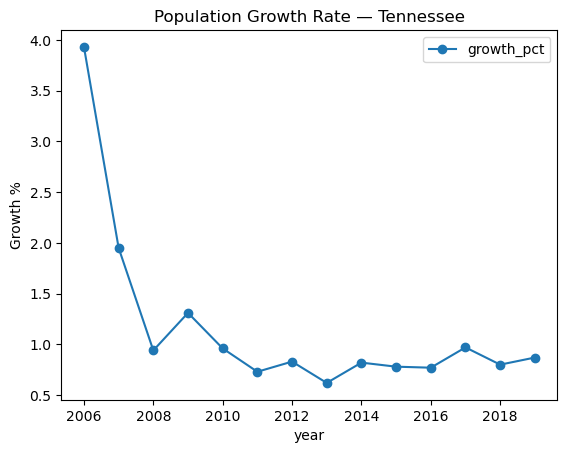

In [22]:
sql_q1 = f"""
SELECT year,
       pop,
       LAG(pop) OVER (ORDER BY year) AS prev_pop,
       ROUND(100.0 * (pop - LAG(pop) OVER (ORDER BY year))
             / NULLIF(LAG(pop) OVER (ORDER BY year), 0), 2) AS growth_pct
FROM public.population
WHERE fips = '{47}'
ORDER BY year;
"""
df_q1 = pd.read_sql(sql_q1, conn)

df_q1.plot(x="year", y="growth_pct", marker="o",
           title="Population Growth Rate — Tennessee")
plt.ylabel("Growth %")
plt.show()


This chart shows the year-over-year population growth rate for Tennessee. The growth rate fluctuates across years, highlighting periods of faster and slower population change.

Question 2

In [23]:
%%ai gpt4 -f code
Write an SQL query to join the income and population tables for your state,
selecting values for all years

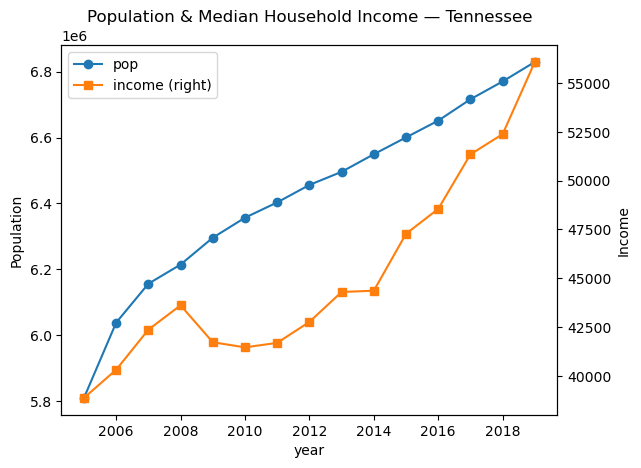

In [24]:
sql_q2 = f"""
SELECT p.year, p.pop, i.income
FROM public.population p
JOIN name_income i
  ON i.fips = p.fips AND i.year = p.year
WHERE p.fips = '{47}'
ORDER BY p.year;
"""
df_q2 = pd.read_sql(sql_q2, conn)

ax = df_q2.plot(x="year", y="pop", marker="o",
                title="Population & Median Household Income — Tennessee")
ax.set_ylabel("Population")
df_q2.plot(x="year", y="income", ax=ax, secondary_y=True, marker="s")
ax.right_ax.set_ylabel("Income")
plt.show()


This dual-axis chart compares Tennessee’s population growth with changes in median household income. While both trend upward, income shows sharper increases in some years relative to population.  


Question 3

In [29]:
%%ai gpt4 -f code
Which decade had the highest average population growth rate in Tennessee?

In [ ]:
# Calculates the population growth rate year over year
tn_df['Population_Growth_Rate'] = tn_df['Population'].pct_change()

# Finds out which decade each year belong to
tn_df['Decade'] = (tn_df['Year'] // 10) * 10 

# Finds the decade with the highest average population growth rate
highest_growth_decade = tn_df.groupby('Decade')['Population_Growth_Rate'].mean().idxmax()
highest_growth_decade

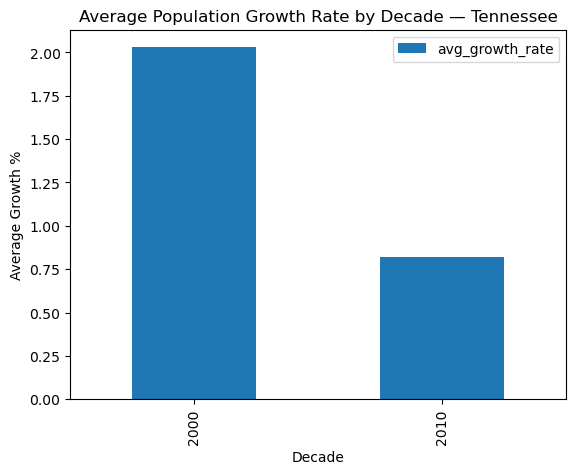

In [30]:
sql_q3 = """
WITH growth AS (
    SELECT year,
           ROUND(100.0 * (pop - LAG(pop) OVER (ORDER BY year))
                 / NULLIF(LAG(pop) OVER (ORDER BY year), 0), 2) AS growth_pct
    FROM public.population
    WHERE fips = '47'
)
SELECT (year / 10) * 10 AS decade,
       ROUND(AVG(growth_pct), 2) AS avg_growth_rate
FROM growth
WHERE growth_pct IS NOT NULL
GROUP BY (year / 10) * 10
ORDER BY avg_growth_rate DESC;
"""
df_q3 = pd.read_sql(sql_q3, conn)

df_q3.plot(x="decade", y="avg_growth_rate", kind="bar",
           title="Average Population Growth Rate by Decade — Tennessee")
plt.ylabel("Average Growth %")
plt.xlabel("Decade")
plt.show()


This chart shows the average annual population growth rate in Tennessee by decade. The tallest bar represents the decade with the highest overall population expansion.  